In [1]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import argparse
import wrds

from scipy.stats import norm

In [3]:
# Connexion à la base de données WRDS
db = wrds.Connection(wrds_username='vince1209')

# Changer le nom après wrds_username pour te connecter, 
# entrer le nom d'utilisateur puis ton mot de passe dans la barre du haut, 
# puis "y" pour ne pas avoir à te reconnecter à chaque fois!

Loading library list...
Done
Done


In [4]:
# Extraction des données CRSP

# Liste des symboles d'actions
stocks = ['V', 'LNC', 'LPLA', 'VRSN', 'LRCX', 'LOGI', 'VLO', 'LYB', 'DVN']
stocks_str = "', '".join(stocks)

stock_query = f"""
SELECT a.date, b.ticker, a.permno, a.ret, a.prc, a.shrout, a.vol,
        a.bid, a.ask
FROM crsp.dsf a
INNER JOIN crsp.dsenames b ON a.permno = b.permno
WHERE b.ticker IN ('{stocks_str}')
AND a.date >= '2011-01-01' 
AND a.date <= '2024-12-31'
AND a.date >= b.namedt 
AND a.date <= b.nameendt
ORDER BY b.ticker, a.date
"""

stock_data_filtered = db.raw_sql(stock_query, date_cols=['date'])

for stock in stocks:
    stock_count = len(stock_data_filtered[stock_data_filtered['ticker'] == stock])
    print(f"{stock}: {stock_count} observations")

V: 3522 observations
LNC: 3522 observations
LPLA: 3522 observations
VRSN: 3522 observations
LRCX: 3522 observations
LOGI: 3522 observations
VLO: 3522 observations
LYB: 3522 observations
DVN: 3522 observations


In [5]:
# Extraction des données SPX
print("🔍 Exécution de la requête SQL pour SPX...")

spx_query = """
SELECT date, spindx as prc
FROM crsp.dsi 
WHERE date >= '2011-01-01' 
AND date <= '2024-12-31'
AND spindx IS NOT NULL
ORDER BY date
"""

spx_data = db.raw_sql(spx_query, date_cols=['date'])

# Calcul des rendements
spx_data = spx_data.sort_values('date')
spx_data['ret'] = spx_data['prc'].pct_change()

spx_data.info()
spx_data

🔍 Exécution de la requête SQL pour SPX...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3522 non-null   datetime64[ns]
 1   prc     3522 non-null   Float64       
 2   ret     3521 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 89.6 KB


,date,prc,ret
0,2011-01-03,1271.87,<NA>
1,2011-01-04,1270.2,-0.001313
2,2011-01-05,1276.56,0.005007
3,2011-01-06,1273.85,-0.002123
4,2011-01-07,1271.5,-0.001845
...,...,...,...
3517,2024-12-24,6040.04,0.011043
3518,2024-12-26,6037.59,-0.000406
3519,2024-12-27,5970.84,-0.011056
3520,2024-12-30,5906.94,-0.010702


In [6]:
# Aperçu des données
stock_data_filtered.info()
stock_data_filtered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31698 entries, 0 to 31697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    31698 non-null  datetime64[ns]
 1   ticker  31698 non-null  string        
 2   permno  31698 non-null  Int64         
 3   ret     31698 non-null  Float64       
 4   prc     31698 non-null  Float64       
 5   shrout  31698 non-null  Float64       
 6   vol     31698 non-null  Float64       
 7   bid     31698 non-null  Float64       
 8   ask     31698 non-null  Float64       
dtypes: Float64(6), Int64(1), datetime64[ns](1), string(1)
memory usage: 2.4 MB


,date,ticker,permno,ret,prc,shrout,vol,bid,ask
0,2011-01-03,DVN,87137,0.002165,78.68,431900.0,2557300.0,78.63,78.64
1,2011-01-04,DVN,87137,-0.006101,78.2,431900.0,2875800.0,78.16,78.17
2,2011-01-05,DVN,87137,0.006394,78.7,431900.0,2885000.0,78.69,78.71
3,2011-01-06,DVN,87137,-0.005972,78.23,431900.0,2462300.0,78.24,78.25
4,2011-01-07,DVN,87137,0.00294,78.46,431900.0,1830900.0,78.47,78.49
...,...,...,...,...,...,...,...,...,...
31693,2024-12-24,VRSN,85753,0.007601,201.48,96100.0,215237.0,201.32001,201.48
31694,2024-12-26,VRSN,85753,0.006204,202.73,96100.0,365131.0,202.62,202.71001
31695,2024-12-27,VRSN,85753,0.006018,203.95,96100.0,564782.0,203.92999,204.03
31696,2024-12-30,VRSN,85753,0.005639,205.10001,96100.0,890432.0,205.08,205.17999


In [7]:
spx_data.info()
spx_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3522 non-null   datetime64[ns]
 1   prc     3522 non-null   Float64       
 2   ret     3521 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 89.6 KB


,date,prc,ret
0,2011-01-03,1271.87,<NA>
1,2011-01-04,1270.2,-0.001313
2,2011-01-05,1276.56,0.005007
3,2011-01-06,1273.85,-0.002123
4,2011-01-07,1271.5,-0.001845
...,...,...,...
3517,2024-12-24,6040.04,0.011043
3518,2024-12-26,6037.59,-0.000406
3519,2024-12-27,5970.84,-0.011056
3520,2024-12-30,5906.94,-0.010702


In [8]:
# 3 janvier 2012 au 3 janvier 2023
start_date = '2012-01-03'
end_date = '2023-01-03'

# Titres à analyser pour l'approche sectorielle complète
# Secteur Technologie: VRSN (VeriSign), LRCX (Lam Research), LOGI (Logitech)
# Secteur Énergie: VLO (Valero Energy), LYB (LyondellBasell), DVN (Devon Energy)
# Autres: V (Visa), LNC (Lincoln National), LPLA (LPL Financial)
titles_to_analyze = {
    'SPX': spx_data[(spx_data['date'] >= start_date) & (spx_data['date'] <= end_date)],
    'V': stock_data_filtered[(stock_data_filtered['ticker'] == 'V') & 
                             (stock_data_filtered['date'] >= start_date) & 
                             (stock_data_filtered['date'] <= end_date)],
    'LNC': stock_data_filtered[(stock_data_filtered['ticker'] == 'LNC') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'LPLA': stock_data_filtered[(stock_data_filtered['ticker'] == 'LPLA') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'VRSN': stock_data_filtered[(stock_data_filtered['ticker'] == 'VRSN') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'LRCX': stock_data_filtered[(stock_data_filtered['ticker'] == 'LRCX') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'LOGI': stock_data_filtered[(stock_data_filtered['ticker'] == 'LOGI') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'VLO': stock_data_filtered[(stock_data_filtered['ticker'] == 'VLO') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'LYB': stock_data_filtered[(stock_data_filtered['ticker'] == 'LYB') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'DVN': stock_data_filtered[(stock_data_filtered['ticker'] == 'DVN') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)]
}

market_index = {'SPX': titles_to_analyze['SPX']}
tech_sector = {
    'VRSN': titles_to_analyze['VRSN'],
    'LRCX': titles_to_analyze['LRCX'],
    'LOGI': titles_to_analyze['LOGI']
}
energy_sector = {
    'VLO': titles_to_analyze['VLO'],
    'LYB': titles_to_analyze['LYB'],
    'DVN': titles_to_analyze['DVN']
}
finance_sector = {
    'V': titles_to_analyze['V'],
    'LNC': titles_to_analyze['LNC'],
    'LPLA': titles_to_analyze['LPLA']
}

## QUESTION a

Analyse de Indice de marché (SPX)
Statistiques descriptives des rendements - SPX:
count      2769.0
mean     0.000461
std      0.010842
min     -0.119841
25%     -0.003702
50%      0.000582
75%      0.005369
max      0.093828
Name: ret, dtype: Float64


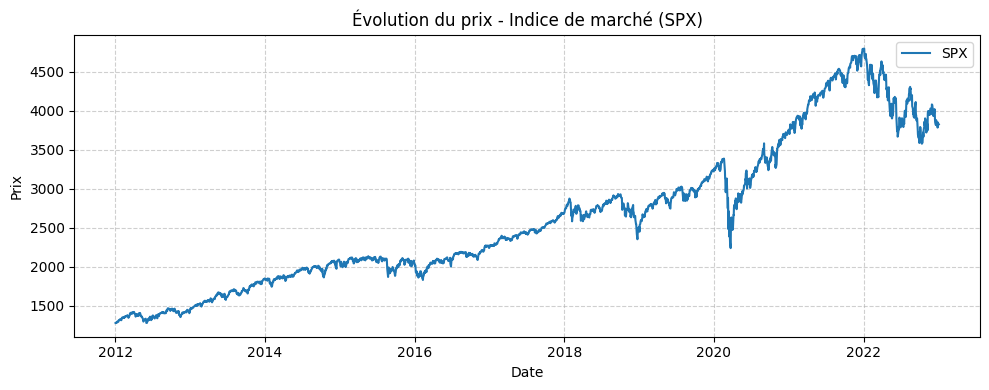

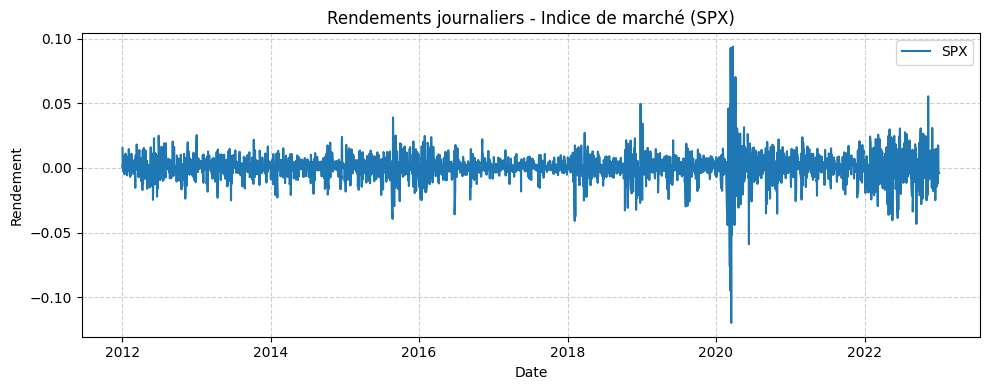

Analyse de Secteur Technologie
Statistiques descriptives des rendements - VRSN:
count      2769.0
mean     0.000765
std      0.016672
min     -0.154721
25%     -0.006727
50%      0.001231
75%      0.008626
max      0.172017
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LRCX:
count      2769.0
mean     0.001211
std      0.024158
min     -0.184277
25%     -0.010666
50%      0.001142
75%      0.013074
max      0.201919
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LOGI:
count      2769.0
mean     0.001126
std      0.023199
min     -0.191825
25%      -0.00965
50%      0.000667
75%      0.011402
max      0.227685
Name: ret, dtype: Float64
count      2769.0
mean     0.000765
std      0.016672
min     -0.154721
25%     -0.006727
50%      0.001231
75%      0.008626
max      0.172017
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LRCX:
count      2769.0
mean     0.001211
std      0.024158
min     -0.184277
25%     -0.010666
50%

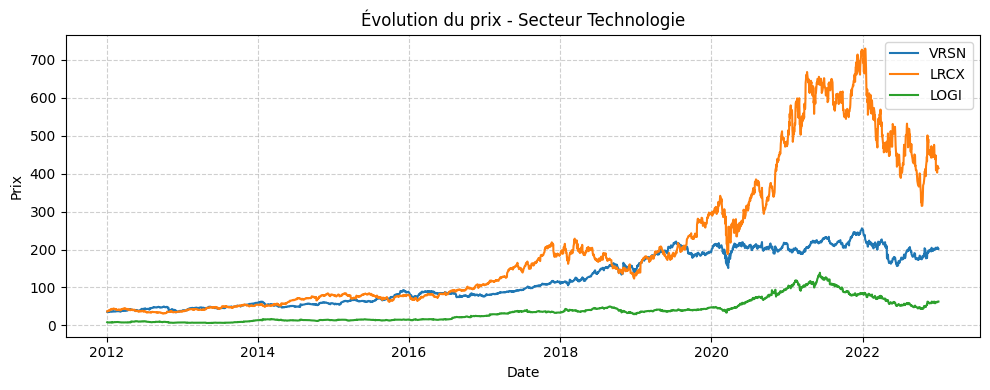

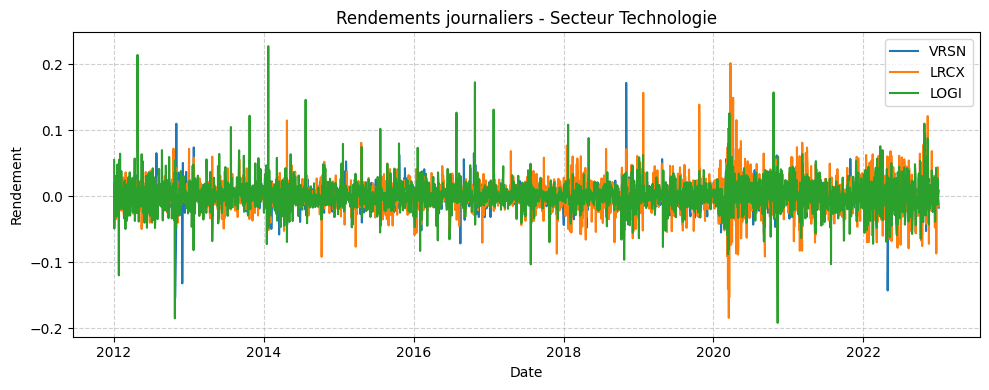

Analyse de Secteur Énergie
Statistiques descriptives des rendements - VLO:
count      2769.0
mean     0.001111
std      0.024739
min     -0.192209
25%     -0.010691
50%      0.001143
75%      0.013335
max      0.312025
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LYB:
count      2769.0
mean     0.000788
std       0.02213
min      -0.25491
25%     -0.009726
50%      0.000619
75%       0.01149
max      0.195415
Name: ret, dtype: Float64
Statistiques descriptives des rendements - DVN:
count      2769.0
mean     0.000574
std      0.031002
min     -0.373972
25%     -0.014061
50%           0.0
75%      0.014749
max      0.210721
Name: ret, dtype: Float64


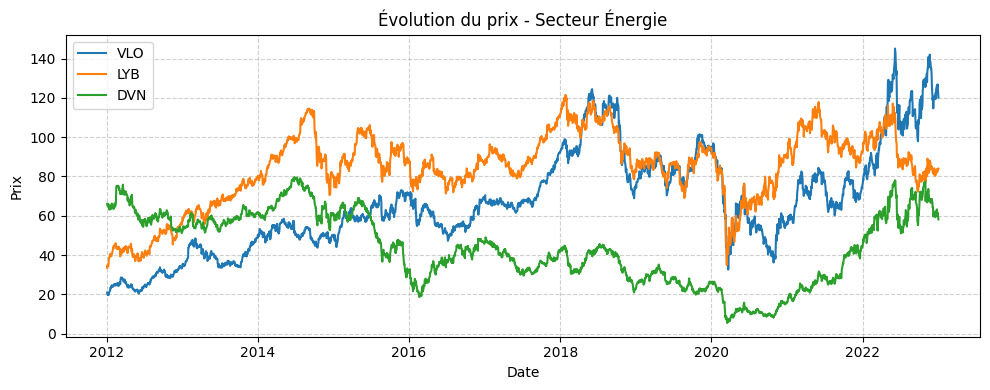

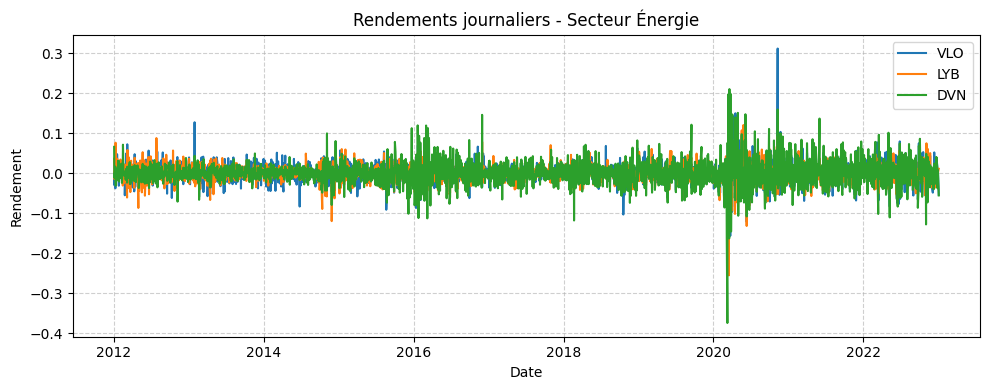

Analyse de Secteur Finance
Statistiques descriptives des rendements - V:
count      2769.0
mean     0.000909
std      0.015642
min     -0.135472
25%     -0.006813
50%      0.001313
75%       0.00875
max      0.138426
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LNC:
count      2769.0
mean     0.000629
std      0.027164
min     -0.331478
25%     -0.010658
50%      0.000964
75%      0.012797
max      0.317003
Name: ret, dtype: Float64
Statistiques descriptives des rendements - LPLA:
count      2769.0
mean     0.001076
std      0.023337
min     -0.346793
25%     -0.008736
50%      0.001374
75%      0.012078
max      0.247351
Name: ret, dtype: Float64


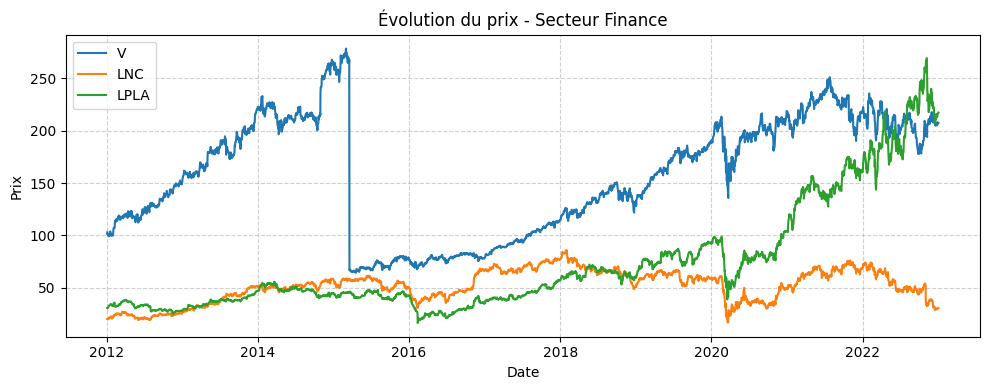

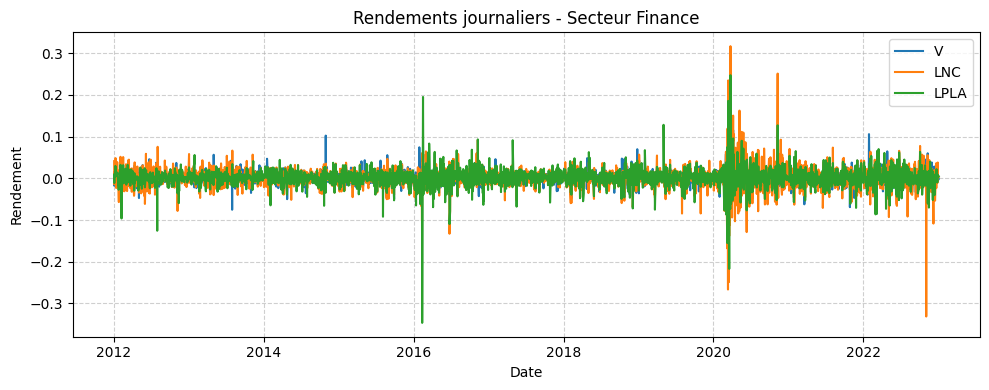

In [9]:
def analyze_sector(sector_name, sector_dict):
    print(f"Analyse de {sector_name}")

    # Statistiques descriptives
    for ticker, df in sector_dict.items():
        print(f"Statistiques descriptives des rendements - {ticker}:")
        print(df['ret'].describe())

    # Série chronologique prix 
    plt.figure(figsize=(10, 4))
    for ticker, df in sector_dict.items():
        df_sorted = df.sort_values('date')
        plt.plot(df_sorted['date'], df_sorted['prc'], label=ticker)
    plt.title(f"Évolution du prix - {sector_name}")
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Rendements 
    plt.figure(figsize=(10, 4))
    for ticker, df in sector_dict.items():
        df_sorted = df.sort_values('date')
        plt.plot(df_sorted['date'], df_sorted['ret'], label=ticker)
    plt.title(f"Rendements journaliers - {sector_name}")
    plt.xlabel('Date')
    plt.ylabel('Rendement')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_sector("Indice de marché (SPX)", market_index)
analyze_sector("Secteur Technologie", tech_sector)
analyze_sector("Secteur Énergie", energy_sector)
analyze_sector("Secteur Finance", finance_sector)

## QUESTION b
                               

In [10]:
# Titres à analyser
titles_for_var = {
    'SPX': titles_to_analyze['SPX'],
    'VRSN': titles_to_analyze['VRSN'],
    'LRCX': titles_to_analyze['LRCX'],
    'LOGI': titles_to_analyze['LOGI'],
    'VLO': titles_to_analyze['VLO'],
    'LYB': titles_to_analyze['LYB'],
    'DVN': titles_to_analyze['DVN'],
}

# Secteurs pour analyse sectorielle
sectors = {
    'Indice de marché': ['SPX'],
    'Secteur Technologie': ['VRSN', 'LRCX', 'LOGI'],
    'Secteur Énergie': ['VLO', 'LYB', 'DVN']
}

In [20]:
def compute_sector_var_es(tickers, titles_for_var, sector_name):
    returns_list = []
    for ticker in tickers:
        df = titles_for_var[ticker].copy()
        df = df.sort_values('date')
        df = df.set_index('date')
        returns_list.append(df['ret'].dropna())

    combined_returns = pd.concat(returns_list, axis=1)
    combined_returns.columns = tickers
    sector_returns = combined_returns.mean(axis=1).dropna()

    # VaR
    var_1 = sector_returns.quantile(0.01)
    var_5 = sector_returns.quantile(0.05)

    # ES 
    es_1 = sector_returns[sector_returns <= var_1].mean()
    es_5 = sector_returns[sector_returns <= var_5].mean()

    # Création du tableau des résultats
    print(f"\nRésultats empiriques – {sector_name}")
    print(f"{'Métrique':<15} {'1%':<12} {'5%':<12}")
    print("-" * 50)
    print(f"{'VaR':<15} {var_1:<12.4%} {var_5:<12.4%}")
    print(f"{'ES':<15} {es_1:<12.4%} {es_5:<12.4%}")
    print("-" * 50)

print("\nRésultats empiriques")
for sector, tickers in sectors.items():
    compute_sector_var_es(tickers, titles_for_var, sector)



Résultats empiriques

Résultats empiriques – Indice de marché
Métrique        1%           5%          
--------------------------------------------------
VaR             -3.1911%     -1.6283%    
ES              -4.5193%     -2.6453%    
--------------------------------------------------

Résultats empiriques – Secteur Technologie
Métrique        1%           5%          
--------------------------------------------------
VaR             -4.8247%     -2.4939%    
ES              -5.8529%     -3.8271%    
--------------------------------------------------

Résultats empiriques – Secteur Énergie
Métrique        1%           5%          
--------------------------------------------------
VaR             -5.5015%     -3.2696%    
ES              -8.1292%     -4.9195%    
--------------------------------------------------


## QUESTION c

In [19]:
def compute_parametric_var_es(tickers, titles_for_var, sector_name):
    returns_list = []

    for ticker in tickers:
        df = titles_for_var[ticker].copy()
        df = df.sort_values('date')
        df = df.set_index('date')
        returns_list.append(df['ret'].dropna())

    combined_returns = pd.concat(returns_list, axis=1)
    combined_returns.columns = tickers
    sector_returns = combined_returns.mean(axis=1).dropna()

    mu = sector_returns.mean()
    sigma = sector_returns.std()

    alpha_1 = 0.01
    alpha_5 = 0.05

    # VaR gaussienne
    var_1 = mu + sigma * norm.ppf(alpha_1)
    var_5 = mu + sigma * norm.ppf(alpha_5)

    # ES gaussienne
    es_1 = mu - sigma * norm.pdf(norm.ppf(alpha_1)) / alpha_1
    es_5 = mu - sigma * norm.pdf(norm.ppf(alpha_5)) / alpha_5

    # Création du tableau des résultats
    print(f"\nRésultats paramétriques – {sector_name}")
    print(f"{'Métrique':<15} {'1%':<12} {'5%':<12}")
    print("-" * 50)
    print(f"{'VaR':<15} {var_1:<12.4%} {var_5:<12.4%}")
    print(f"{'ES':<15} {es_1:<12.4%} {es_5:<12.4%}")
    print("-" * 50)

print("\nRésultats paramétriques")
for sector, tickers in sectors.items():
    compute_parametric_var_es(tickers, titles_for_var, sector)



Résultats paramétriques

Résultats paramétriques – Indice de marché
Métrique        1%           5%          
--------------------------------------------------
VaR             -2.4762%     -1.7373%    
ES              -2.8436%     -2.1904%    
--------------------------------------------------

Résultats paramétriques – Secteur Technologie
Métrique        1%           5%          
--------------------------------------------------
VaR             -3.7421%     -2.6156%    
ES              -4.3023%     -3.3063%    
--------------------------------------------------

Résultats paramétriques – Secteur Énergie
Métrique        1%           5%          
--------------------------------------------------
VaR             -4.9320%     -3.4631%    
ES              -5.6624%     -4.3638%    
--------------------------------------------------


## QUESTION d

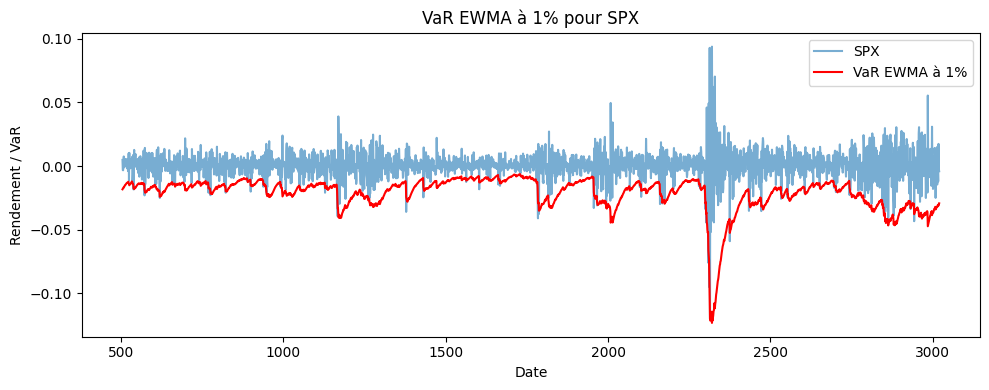

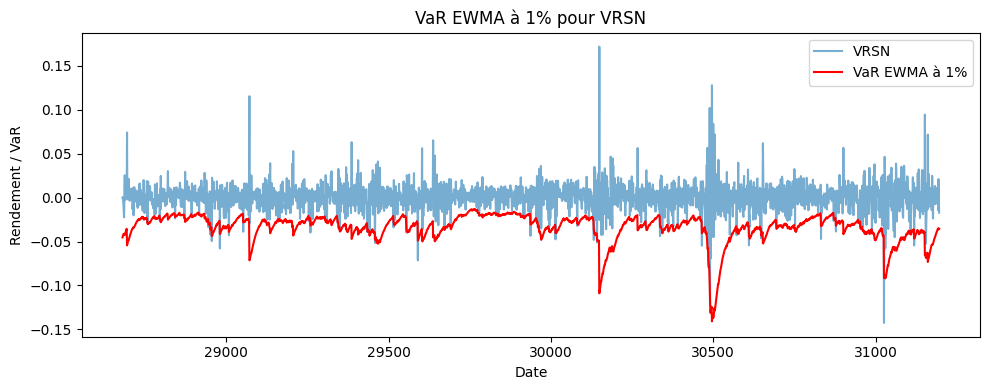

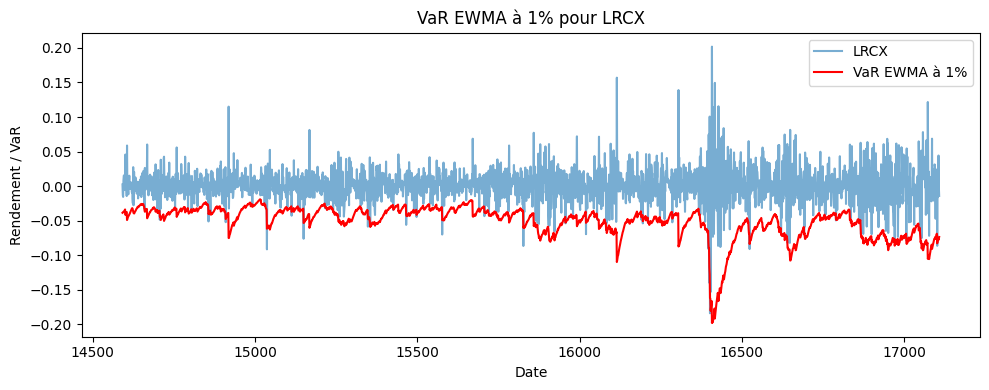

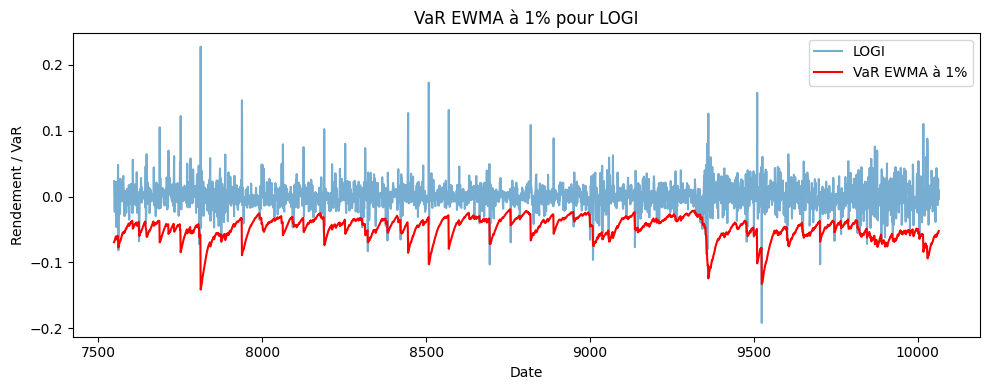

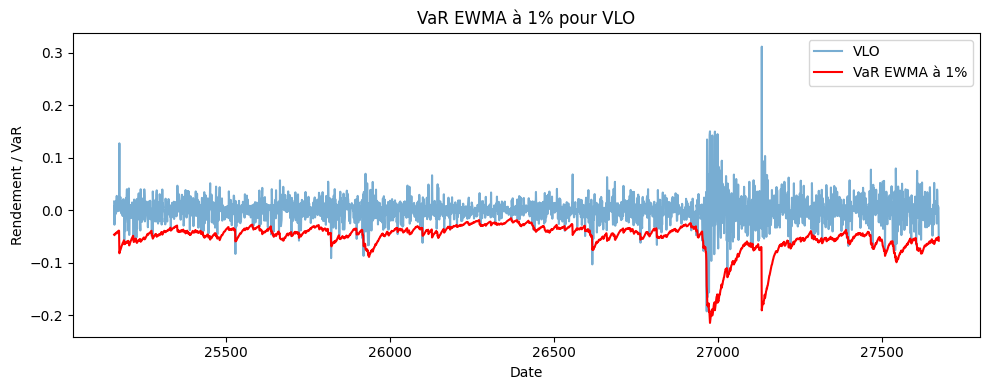

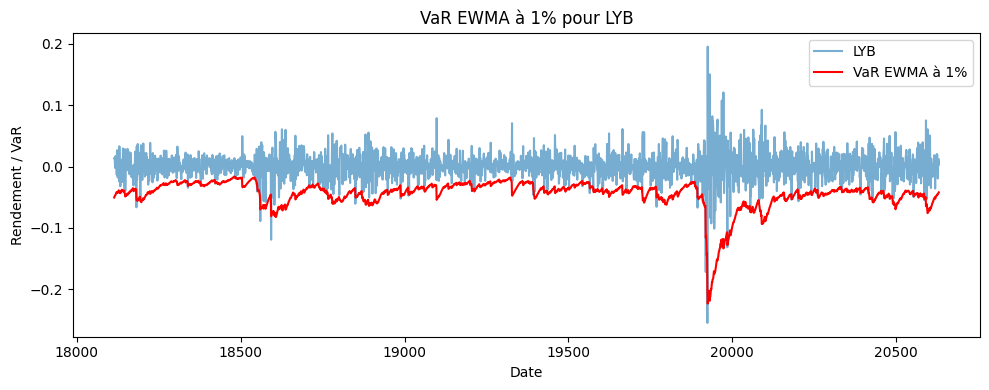

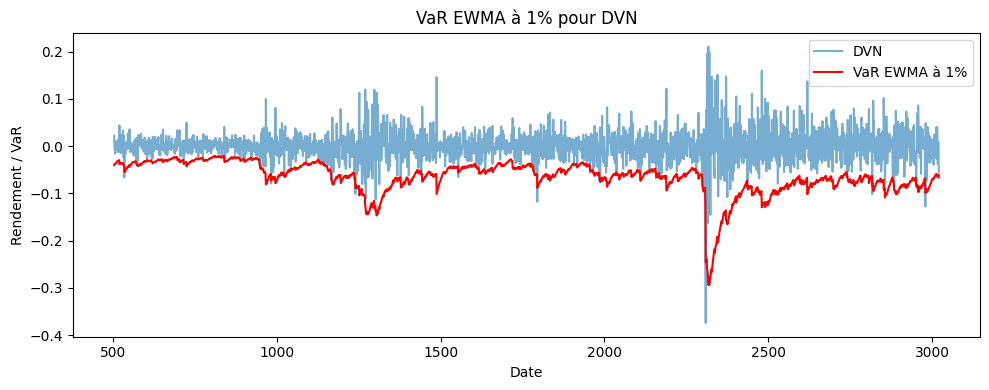

In [ ]:
def plot_ewma_var_individual(tickers, titles_dict, lambda_=0.94, alpha=0.05):
    window = 252
    z = np.percentile(np.random.randn(100000), alpha * 100)

    for ticker in tickers:
        df = titles_dict[ticker].copy()
        returns = df['ret'].dropna()
        dates = returns.index

        ewma_var = [np.var(returns[:window])]
        for r in returns[window:]:
            new_var = lambda_ * ewma_var[-1] + (1 - lambda_) * r**2
            ewma_var.append(new_var)

        sigma = np.sqrt(ewma_var)
        mu = returns.mean()
        var_series = mu + z * sigma

        var_dates = dates[window:]
        realized_returns = returns[window:]

        # Tracer
        plt.figure(figsize=(10, 4))
        plt.plot(var_dates, realized_returns, label=ticker, alpha=0.6)
        plt.plot(var_dates, var_series[1:], label='VaR EWMA à 5%', color='red')
        plt.title(f'VaR EWMA à 5% pour {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Rendement / VaR')
        plt.legend()
        plt.tight_layout()
        plt.show()

all_tickers = ['SPX', 'VRSN', 'LRCX', 'LOGI', 'VLO', 'LYB', 'DVN']

plot_ewma_var_individual(all_tickers, titles_for_var)

## QUESTION e

In [57]:
# Création choc (7 jours)
def generate_shock(last_date):
    # Utiliser la vraie dernière date des données + 1 jour pour le choc
    start_date = last_date + pd.Timedelta(days=1)
    shock_dates = pd.bdate_range(start=start_date, periods=7)
    shock_returns = pd.Series([-0.11, -0.09, -0.08, -0.07, -0.05, -0.03, -0.02], index=shock_dates)
    shock_returns.index.name = 'date'
    return shock_returns

In [58]:
# VaR Historique 
def var_historique(x, alpha=0.05):
    return np.quantile(x, alpha)

# VaR Gaussienne 
def var_gaussienne(returns, window, alpha=0.05):
    mu = returns.rolling(window).mean()
    sigma = returns.rolling(window).std()
    z = norm.ppf(alpha)
    return mu + z * sigma

# VaR Récursive (EWMA)
def var_ewma(returns, alpha=0.05, lambda_=0.94):
    ewma_var = []
    squared_returns = returns**2
    var = squared_returns.iloc[0] 
    for r2 in squared_returns:
        var = lambda_ * var + (1 - lambda_) * r2
        ewma_var.append(var)
    ewma_vol = np.sqrt(pd.Series(ewma_var, index=returns.index))
    z = norm.ppf(alpha)
    mu = returns.mean()
    return mu + z * ewma_vol

Analyse de l'impact du choc pour SPX dans le Indice de marché
Données extraites: 2769 observations de 2012-01-03 à 2023-01-03
Période des données: 2012-01-03 à 2023-01-03
Période du choc: 2023-01-04 à 2023-01-12


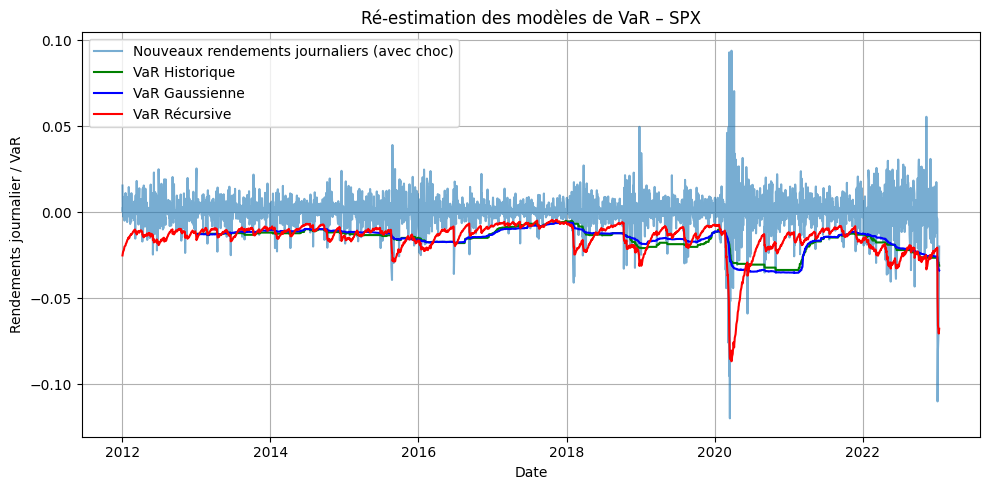


ANALYSE DE LA VITESSE D'ADAPTATION - SPX
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0265      -0.0296      -11.6       %
VaR Gaussienne     -0.0256      -0.0322      -25.7       %
VaR EWMA           -0.0230      -0.0644      -179.9      %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - SPX
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique   

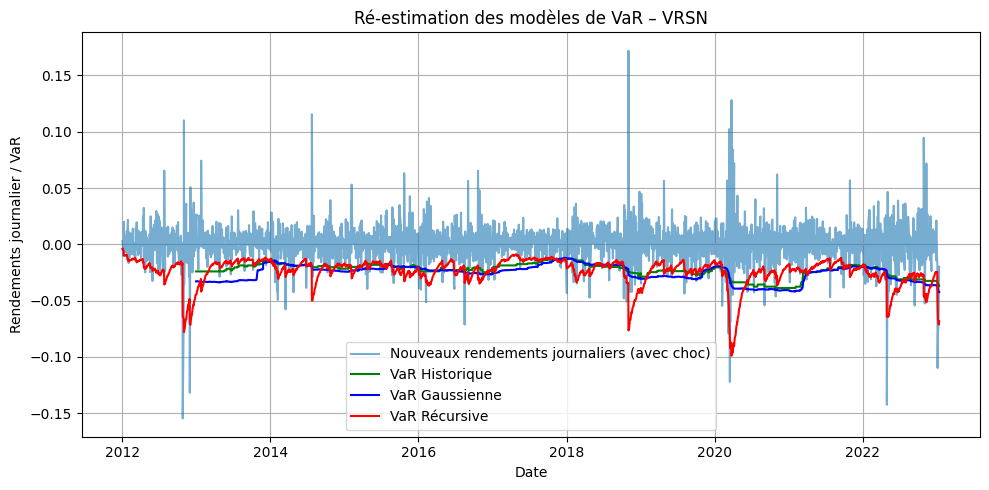


ANALYSE DE LA VITESSE D'ADAPTATION - VRSN
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0326      -0.0359      -10.2       %
VaR Gaussienne     -0.0364      -0.0413      -13.4       %
VaR EWMA           -0.0294      -0.0654      -122.5      %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - VRSN
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique 

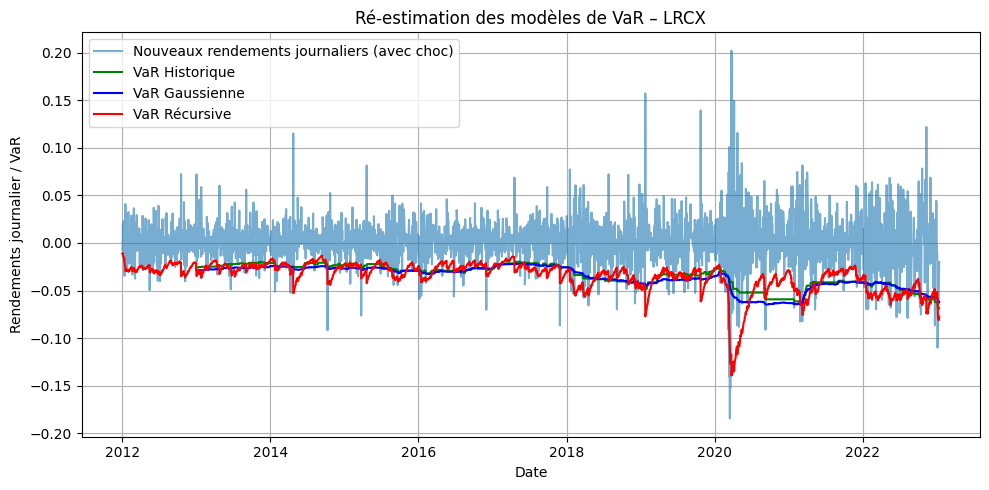


ANALYSE DE LA VITESSE D'ADAPTATION - LRCX
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0602      -0.0677      -12.3       %
VaR Gaussienne     -0.0570      -0.0612      -7.3        %
VaR EWMA           -0.0538      -0.0769      -43.0       %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - LRCX
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique 

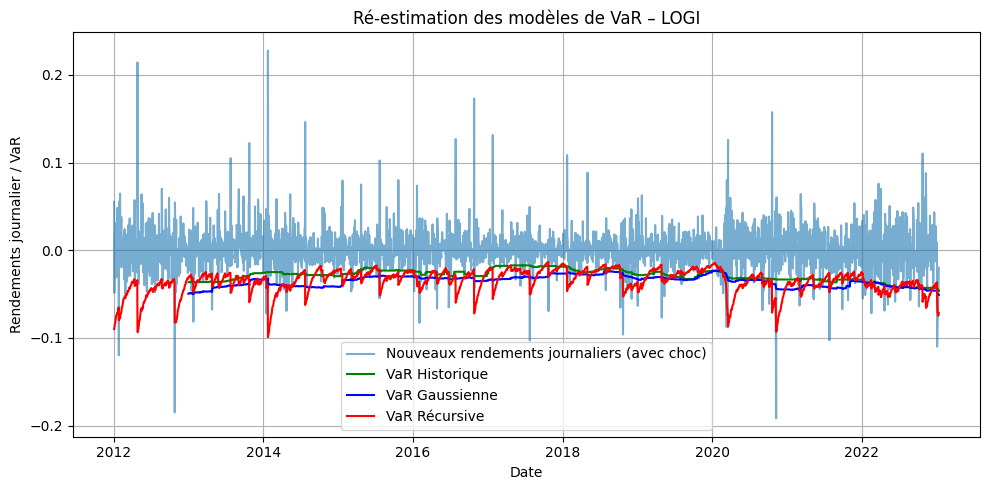


ANALYSE DE LA VITESSE D'ADAPTATION - LOGI
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0429      -0.0449      -4.4        %
VaR Gaussienne     -0.0460      -0.0500      -8.7        %
VaR EWMA           -0.0419      -0.0696      -65.9       %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - LOGI
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique 

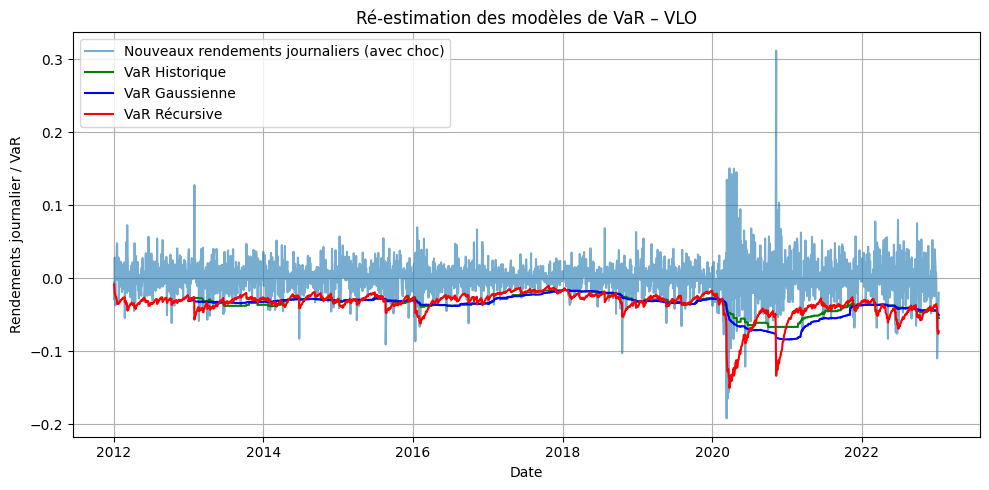


ANALYSE DE LA VITESSE D'ADAPTATION - VLO
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0448      -0.0529      -18.0       %
VaR Gaussienne     -0.0438      -0.0492      -12.2       %
VaR EWMA           -0.0400      -0.0713      -78.1       %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - VLO
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique   

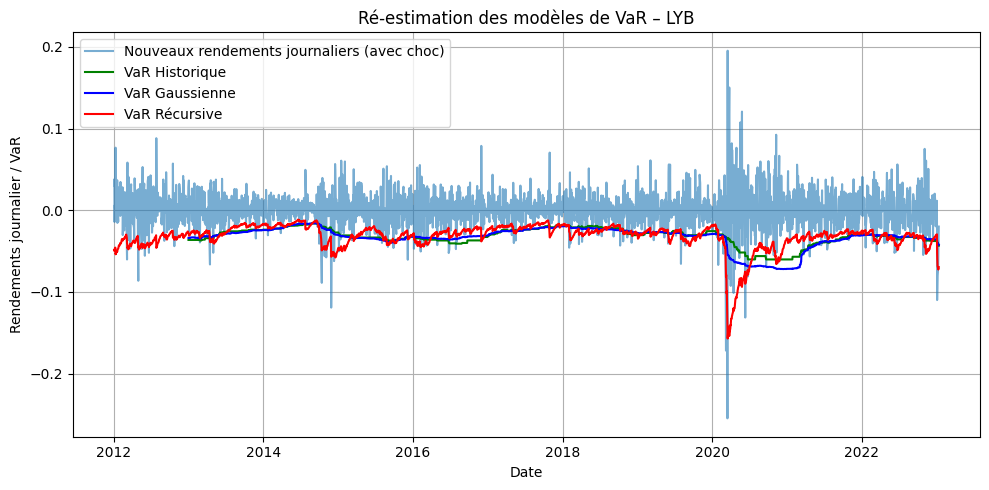


ANALYSE DE LA VITESSE D'ADAPTATION - LYB
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0375      -0.0415      -10.4       %
VaR Gaussienne     -0.0355      -0.0407      -14.7       %
VaR EWMA           -0.0350      -0.0670      -91.3       %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - LYB
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique   

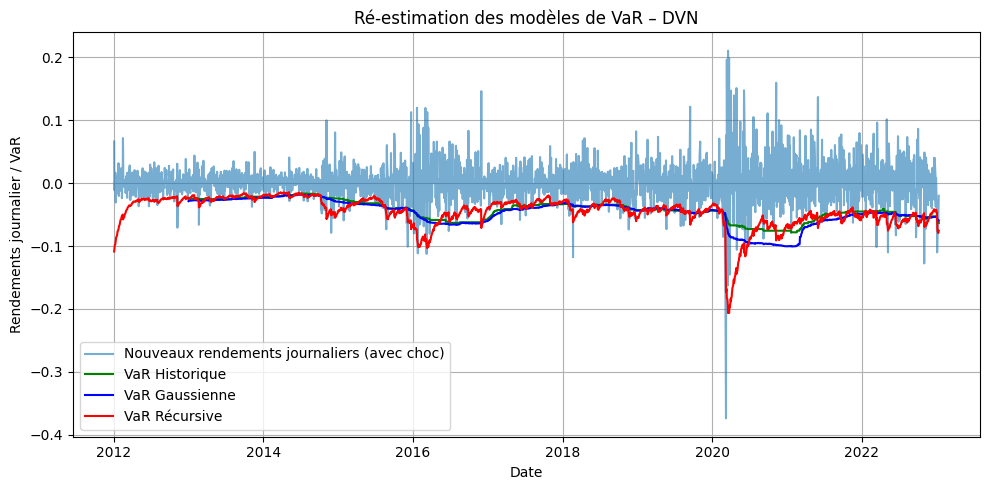


ANALYSE DE LA VITESSE D'ADAPTATION - DVN
Date de fin des données originales: 2023-01-03
Date de début du choc: 2023-01-04
Observations avant choc: 20
Observations de choc: 7
Modèle             Avant Choc   Pendant Choc Changement  
-------------------------------------------------------
VaR Historique     -0.0530      -0.0612      -15.4       %
VaR Gaussienne     -0.0540      -0.0583      -8.0        %
VaR EWMA           -0.0453      -0.0745      -64.6       %
-------------------------------------------------------
Interprétation:
   • Un changement plus important = adaptation plus rapide au choc
   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)
   • VaR Historique devrait être le plus lent à s'adapter
   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc


TEST DE COUVERTURE - DVN
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique   

In [59]:
def analyze_shock_impact(returns_series, name, window=250):
    
    # S'assurer que l'index est datetime ET reset si nécessaire
    if not isinstance(returns_series.index, pd.DatetimeIndex):
        
        # Récupérer les données originales avec les vraies dates
        ticker_data = titles_for_var[name].copy()
        ticker_data = ticker_data.sort_values('date')
        ticker_data = ticker_data.set_index('date')
        returns_series = ticker_data['ret'].dropna()
        
    # Vérifier les dates
    print(f"Période des données: {returns_series.index[0].strftime('%Y-%m-%d')} à {returns_series.index[-1].strftime('%Y-%m-%d')}")
    
    shock = generate_shock(returns_series.index[-1])
    print(f"Période du choc: {shock.index[0].strftime('%Y-%m-%d')} à {shock.index[-1].strftime('%Y-%m-%d')}")
    
    # Calcule retour historique avec choc
    full_returns = pd.concat([returns_series, shock])
    full_returns.index = pd.to_datetime(full_returns.index, errors='coerce')
    full_returns = full_returns.dropna()
    full_returns = full_returns.sort_index()
    
    # Recalcule VaR après choc
    var_hist = full_returns.rolling(window).apply(var_historique)
    var_gauss = var_gaussienne(full_returns, window)
    var_ewma_series = var_ewma(full_returns)
    
    plt.figure(figsize=(10, 5))
    plt.plot(full_returns.index, full_returns, label="Nouveaux rendements journaliers (avec choc)", alpha=0.6)
    plt.plot(var_hist.index, var_hist, label="VaR Historique", color="green")
    plt.plot(var_gauss.index, var_gauss, label="VaR Gaussienne", color="blue")
    plt.plot(var_ewma_series.index, var_ewma_series, label="VaR Récursive", color="red")
    plt.title(f"Ré-estimation des modèles de VaR – {name}")
    plt.xlabel("Date")
    plt.ylabel("Rendements journalier / VaR")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return var_hist, var_gauss, var_ewma_series, full_returns

sectors = {
    'Indice de marché': ['SPX'],
    'Secteur Technologie': ['VRSN', 'LRCX', 'LOGI'],
    'Secteur Énergie': ['VLO', 'LYB', 'DVN']
}   

for sector, tickers in sectors.items():
    for ticker in tickers:
        print(f"Analyse de l'impact du choc pour {ticker} dans le {sector}")
        
        # CORRECTION : Extraire correctement les données avec l'index datetime
        ticker_df = titles_for_var[ticker].copy()
        ticker_df = ticker_df.sort_values('date')
        ticker_df = ticker_df.set_index('date')
        returns_series = ticker_df['ret'].dropna()
        
        print(f"Données extraites: {len(returns_series)} observations de {returns_series.index[0].strftime('%Y-%m-%d')} à {returns_series.index[-1].strftime('%Y-%m-%d')}")
        
        # Analyse graphique avec retour des valeurs
        var_hist, var_gauss, var_ewma_series, full_returns = analyze_shock_impact(returns_series, ticker)
        
        # Analyse quantitative de la vitesse d'adaptation
        analyze_adaptation_speed_simple(var_hist, var_gauss, var_ewma_series, full_returns, ticker)
        
        # Test de couverture automatique
        perform_coverage_test(var_hist, var_gauss, var_ewma_series, full_returns, ticker)
        
        print(f"Analyse terminée pour {ticker}")
        print("=" * 70)

In [60]:
# Analyse de la vitesse d'adaptation après le choc
def analyze_adaptation_speed_simple(var_hist, var_gauss, var_ewma, full_returns, name):
    """
    Analyse simple de la vitesse d'adaptation des modèles VaR
    """
    print(f"\nANALYSE DE LA VITESSE D'ADAPTATION - {name}")
    print("=" * 55)
    
    # Trouver la vraie date du choc (dernière date des données originales)
    original_data_end = full_returns.index[-8]  # 7 jours avant la fin (le choc fait 7 jours)
    shock_start_date = original_data_end + pd.Timedelta(days=1)
    
    print(f"Date de fin des données originales: {original_data_end.strftime('%Y-%m-%d')}")
    print(f"Date de début du choc: {shock_start_date.strftime('%Y-%m-%d')}")
    
    # Période avant le choc (30 derniers jours des données originales)
    pre_shock_mask = (full_returns.index >= original_data_end - pd.Timedelta(days=30)) & (full_returns.index <= original_data_end)
    
    # Période du choc (7 jours de choc)
    shock_mask = full_returns.index > original_data_end
    
    print(f"Observations avant choc: {pre_shock_mask.sum()}")
    print(f"Observations de choc: {shock_mask.sum()}")
    
    if pre_shock_mask.sum() < 5 or shock_mask.sum() < 5:
        print("Pas assez de données pour l'analyse")
        return
    
    models = {
        'VaR Historique': var_hist,
        'VaR Gaussienne': var_gauss,
        'VaR EWMA': var_ewma
    }
    
    print(f"{'Modèle':<18} {'Avant Choc':<12} {'Pendant Choc':<12} {'Changement':<12}")
    print("-" * 55)
    
    for model_name, var_series in models.items():
        if var_series is not None and len(var_series) > 0:
            # VaR moyenne avant le choc
            pre_var = var_series[pre_shock_mask].mean() if pre_shock_mask.sum() > 0 else np.nan
            
            # VaR moyenne pendant le choc
            shock_var = var_series[shock_mask].mean() if shock_mask.sum() > 0 else np.nan
            
            if not (np.isnan(pre_var) or np.isnan(shock_var)):
                change_pct = ((shock_var - pre_var) / abs(pre_var)) * 100
                print(f"{model_name:<18} {pre_var:<12.4f} {shock_var:<12.4f} {change_pct:<12.1f}%")
            else:
                print(f"{model_name:<18} {'N/A':<12} {'N/A':<12} {'N/A':<12}")
    
    print("-" * 55)
    print("Interprétation:")
    print("   • Un changement plus important = adaptation plus rapide au choc")
    print("   • VaR EWMA devrait réagir le plus rapidement (changement le plus important)")
    print("   • VaR Historique devrait être le plus lent à s'adapter")
    print("   • Les valeurs négatives indiquent une VaR plus conservatrice après le choc")
    print()
    
    return True

## QUESTION f

In [61]:
def test_couverture(var_series, realized_returns, alpha=0.05):
    # Alignement des séries
    realized_returns, var_series = realized_returns.align(var_series, join='inner')

    # Violations : quand la perte est plus grande que la VaR
    violations = realized_returns < var_series

    T = len(var_series)
    nb_violations = violations.sum()
    
    # Proportion observée de violations
    p_hat = nb_violations / T

    # Statistique S (approximation normale)
    S = (nb_violations - alpha * T) / ((alpha * (1 - alpha) * T) ** 0.5)

    return S, nb_violations, T, p_hat

def perform_coverage_test(var_hist, var_gauss, var_ewma, returns, name):
    
    models = {
        'VaR Historique': var_hist,
        'VaR Gaussienne': var_gauss,
        'VaR EWMA': var_ewma
    }
    
    print(f"\nTEST DE COUVERTURE - {name}")
    print(f"{'Modèle':<18} {'Violations':<12} {'Taux Obs.':<10} {'Stat. S':<10} {'Résultat':<15}")
    print("-" * 65)
    
    for model_name, var_series in models.items():
        if var_series is not None and len(var_series) > 0:
            S, nb_viol, T, p_hat = test_couverture(var_series, returns, alpha=0.05)
            
            # Test avec statistique S : |S| <= 1.96 pour seuil de 5%
            if abs(S) <= 1.96:
                result = "Accepté"
            else:
                result = "Rejeté"
            
            print(f"{model_name:<18} {nb_viol}/{T:<8} {p_hat:<10.3%} {S:<10.2f} {result:<15}")
        else:
            print(f"{model_name:<18} {'N/A':<12} {'N/A':<10} {'N/A':<10} {'N/A':<15}")
    
    print("-" * 65)
    print("Interprétation:")
    print("   • Statistique S : |S| <= 1.96 → modèle accepté (seuil 5%)")
    print("   • Taux attendu : 5.00% (alpha = 5%)")
    print("   • Accepté = Taux de violation correct")
    print("   • Rejeté = Taux de violation incorrect")
    print("   • Trop peu de violations = sous-estimation du risque")
    print("   • Trop de violations = surestimation du risque")
    print()

# Extraire les données pour SPX comme exemple
ticker_df = titles_for_var['SPX'].copy()
ticker_df = ticker_df.sort_values('date')
ticker_df = ticker_df.set_index('date')
returns_series = ticker_df['ret'].dropna()

# Calculer les VaR pour SPX
window = 250
var_hist_example = returns_series.rolling(window).apply(var_historique)
var_gauss_example = var_gaussienne(returns_series, window)
var_ewma_example = var_ewma(returns_series)

# Effectuer le test de couverture
perform_coverage_test(var_hist_example, var_gauss_example, var_ewma_example, returns_series, "SPX")


TEST DE COUVERTURE - SPX
Modèle             Violations   Taux Obs.  Stat. S    Résultat       
-----------------------------------------------------------------
VaR Historique     140/2769     5.056%     0.14       Accepté        
VaR Gaussienne     152/2769     5.489%     1.18       Accepté        
VaR EWMA           146/2769     5.273%     0.66       Accepté        
-----------------------------------------------------------------
Interprétation:
   • Statistique S : |S| <= 1.96 → modèle accepté (seuil 5%)
   • Taux attendu : 5.00% (alpha = 5%)
   • Accepté = Taux de violation correct
   • Rejeté = Taux de violation incorrect
   • Trop peu de violations = sous-estimation du risque
   • Trop de violations = surestimation du risque



## QUESTION g

In [63]:
def test_sequences(violations):
    violations = violations.dropna()

    # Convertit les booléens en int (1 = violation, 0 = pas violation)
    v = violations.astype(int).values

    # Nombre total de violations et non-violations
    n1 = v.sum()          
    n0 = len(v) - n1      

    # Nombre de séquences = transitions entre 0 et 1
    seq = 1 + np.sum(v[1:] != v[:-1])

    # Espérance et écart-type sous H0 
    expected = 1 + 2 * n0 * n1 / (n0 + n1)
    std = (2 * n0 * n1 * (2 * n0 * n1 - n0 - n1)) / ((n0 + n1)**2 * (n0 + n1 - 1))
    std = std**0.5

    Z = (seq - expected) / std

    return seq, expected, Z

def perform_sequences_test(var_hist, var_gauss, var_ewma, returns, name):
    
    models = {
        'VaR Historique': var_hist,
        'VaR Gaussienne': var_gauss,
        'VaR EWMA': var_ewma
    }
    
    print(f"\nTEST DE SÉQUENCES - {name}")
    print(f"{'Modèle':<18} {'Runs Obs.':<12} {'Runs Att.':<12} {'Stat. Z':<10} {'Résultat':<15}")
    print("-" * 70)
    
    for model_name, var_series in models.items():
        if var_series is not None and len(var_series) > 0:
            aligned_returns, aligned_var = returns.align(var_series, join='inner')
            violations = aligned_returns < aligned_var
            
            if len(violations) > 0:
                runs_obs, runs_exp, Z = test_sequences(violations)
                
                # Test avec |Z| <= 1.96 pour seuil de 5%
                if abs(Z) <= 1.96:
                    result = "Accepté"
                else:
                    result = "Rejeté"
                
                print(f"{model_name:<18} {runs_obs:<12} {runs_exp:<12.2f} {Z:<10.2f} {result:<15}")
            else:
                print(f"{model_name:<18} {'N/A':<12} {'N/A':<12} {'N/A':<10} {'N/A':<15}")
        else:
            print(f"{model_name:<18} {'N/A':<12} {'N/A':<12} {'N/A':<10} {'N/A':<15}")
    
    print("-" * 70)
    print("Interprétation:")
    print("   • |Z| <= 1.96 → violations aléatoires (bon modèle)")
    print("   • |Z| > 1.96 → violations regroupées (modèle défaillant)")
    print("   • Z négatif → trop de regroupement (clusters)")
    print("   • Z positif → trop de dispersion")
    print()
    print("Impact financier du regroupement:")
    print("   • Clusters de violations → risque systémique sous-estimé")
    print("   • Réaction des gestionnaires → ajustements tardifs et excessifs")
    print("   • Conséquences → pertes amplifiées, liquidations forcées")
    print()

# Extraire les données pour SPX 
ticker_df = titles_for_var['SPX'].copy()
ticker_df = ticker_df.sort_values('date')
ticker_df = ticker_df.set_index('date')
returns_series = ticker_df['ret'].dropna()

# Calculer les VaR pour SPX
window = 250
var_hist_example = returns_series.rolling(window).apply(var_historique)
var_gauss_example = var_gaussienne(returns_series, window)
var_ewma_example = var_ewma(returns_series)

# Effectuer le test de séquences
perform_sequences_test(var_hist_example, var_gauss_example, var_ewma_example, returns_series, "SPX")

print("\nContexte financier détaillé:")
print("=" * 50)
print("Le regroupement de violations indique que:")
print("• Les modèles VaR manquent des dynamiques temporelles importantes")
print("• La volatilité présente des clusters non capturés")
print("• Les corrélations en période de stress sont sous-estimées")
print("\nConséquences pour la gestion de portefeuille:")
print("• Sous-allocation de capital en période normale")
print("• Sur-réaction tardive lors des crises")
print("• Risque de liquidité amplifié")
print("• Pertes en cascade non anticipées")


TEST DE SÉQUENCES - SPX
Modèle             Runs Obs.    Runs Att.    Stat. Z    Résultat       
----------------------------------------------------------------------
VaR Historique     239          265.44       -5.03      Rejeté         
VaR Gaussienne     257          286.66       -5.22      Rejeté         
VaR EWMA           271          277.60       -1.26      Accepté        
----------------------------------------------------------------------
Interprétation:
   • |Z| <= 1.96 → violations aléatoires (bon modèle)
   • |Z| > 1.96 → violations regroupées (modèle défaillant)
   • Z négatif → trop de regroupement (clusters)
   • Z positif → trop de dispersion

Impact financier du regroupement:
   • Clusters de violations → risque systémique sous-estimé
   • Réaction des gestionnaires → ajustements tardifs et excessifs
   • Conséquences → pertes amplifiées, liquidations forcées


Contexte financier détaillé:
Le regroupement de violations indique que:
• Les modèles VaR manquent des dyn

## Interprétation financière du test de séquences

### Analyse des résultats SPX :

**Résultats observés :**
- **VaR Historique** : Z = -5.03 (fortement rejeté)
- **VaR Gaussienne** : Z = -5.22 (fortement rejeté)  
- **VaR EWMA** : Z = -1.26 (accepté)

Les valeurs Z négatives indiquent un **regroupement excessif de violations** (clustering), particulièrement prononcé pour les modèles historique et gaussien.

### Implications pour le comportement des gestionnaires de fonds :

#### 1. **Sous-estimation systémique du risque en période normale**
- Les gestionnaires s'habituent à des VaR qui fonctionnent bien la plupart du temps
- Accumulation progressive de positions risquées basées sur une fausse sécurité
- Allocation de capital insuffisante pour couvrir les risques réels

#### 2. **Réactions en cascade lors des crises (clustering)**
- **Moment T** : Première violation importante → panique généralisée
- **Moments T+1, T+2...** : Violations successives créent un effet domino
- Les gestionnaires réagissent tous simultanément → amplification des mouvements de marché

#### 3. **Comportement procyclique dommageable**
- **Phase ascendante** : Sous-estimation du risque → levier excessif
- **Phase descendante** : Sur-réaction → ventes forcées massives
- Création de bulles suivies d'éclatements brutaux

#### 4. **Impact sur la liquidité de marché**
- Les violations groupées coïncident souvent avec des stress de liquidité
- Tous les gestionnaires cherchent à vendre simultanément
- Spirale baissière : ventes → baisse des prix → nouvelles violations → nouvelles ventes

#### 5. **Défaillances de la gestion des risques institutionnels**
- Les modèles VaR défaillants (historique, gaussien) sont encore largement utilisés
- Les comités de risque réagissent avec retard aux signaux d'alarme
- Pertes concentrées sur de courtes périodes au lieu d'être étalées

### Recommandations pratiques :

1. **Privilégier le modèle EWMA** qui capture mieux la dynamique temporelle
2. **Implémenter des stress-tests** complémentaires aux modèles VaR
3. **Diversifier temporellement** les ajustements de portefeuille
4. **Mettre en place des mécanismes contra-cycliques** de gestion des risques

In [ ]:
# Analyse quantitative du clustering de violations pour SPX
def analyze_clustering_impact(returns_series, var_series, name):
    """
    Analyse l'impact financier du clustering de violations
    """
    aligned_returns, aligned_var = returns_series.align(var_series, join='inner')
    violations = aligned_returns < aligned_var
    
    print(f"ANALYSE DU CLUSTERING - {name}")
    print("=" * 50)
    
    # Identifier les périodes de clustering
    violation_diff = violations.astype(int).diff()
    cluster_starts = violation_diff[violation_diff == 1].index
    cluster_ends = violation_diff[violation_diff == -1].index
    
    # Ajuster pour les clusters qui commencent/finissent aux extrémités
    if violations.iloc[0]:
        cluster_starts = cluster_starts.insert(0, violations.index[0])
    if violations.iloc[-1]:
        cluster_ends = cluster_ends.insert(len(cluster_ends), violations.index[-1])
    
    # Calculer les statistiques de clustering
    cluster_lengths = []
    cluster_losses = []
    
    for i in range(min(len(cluster_starts), len(cluster_ends))):
        start = cluster_starts[i]
        end = cluster_ends[i] if i < len(cluster_ends) else violations.index[-1]
        
        cluster_period = aligned_returns[start:end]
        cluster_length = len(cluster_period)
        cumulative_loss = cluster_period.sum()
        
        if cluster_length > 1:  # Seulement les vrais clusters
            cluster_lengths.append(cluster_length)
            cluster_losses.append(cumulative_loss)
    
    if cluster_lengths:
        print(f"Nombre de clusters détectés: {len(cluster_lengths)}")
        print(f"Longueur moyenne des clusters: {np.mean(cluster_lengths):.1f} jours")
        print(f"Longueur maximale: {max(cluster_lengths)} jours")
        print(f"Perte cumulée moyenne par cluster: {np.mean(cluster_losses):.4%}")
        print(f"Pire cluster (perte cumulée): {min(cluster_losses):.4%}")
        
        # Impact sur la performance
        total_violations = violations.sum()
        clustered_violations = sum(cluster_lengths)
        clustering_ratio = clustered_violations / total_violations if total_violations > 0 else 0
        
        print(f"Ratio de violations clustérisées: {clustering_ratio:.1%}")
        
        # Périodes de stress identifiées
        if cluster_losses:
            worst_clusters = sorted(enumerate(cluster_losses), key=lambda x: x[1])[:3]
            print(f"\nTop 3 des périodes de stress les plus sévères:")
            for i, (idx, loss) in enumerate(worst_clusters):
                if idx < len(cluster_starts) and idx < len(cluster_ends):
                    start_date = cluster_starts[idx]
                    end_date = cluster_ends[idx] if idx < len(cluster_ends) else violations.index[-1]
                    print(f"  {i+1}. {start_date.strftime('%Y-%m-%d')} à {end_date.strftime('%Y-%m-%d')}: {loss:.4%}")
    else:
        print("Aucun cluster significatif détecté")
    
    print("-" * 50)
    return cluster_lengths, cluster_losses

# Analyser le clustering pour les différents modèles VaR sur SPX
models = {
    'VaR Historique': var_hist_example,
    'VaR Gaussienne': var_gauss_example,
    'VaR EWMA': var_ewma_example
}

for model_name, var_series in models.items():
    if var_series is not None and len(var_series) > 0:
        print(f"\n{model_name.upper()}")
        cluster_lengths, cluster_losses = analyze_clustering_impact(returns_series, var_series, model_name)
        
        # Calculer l'impact financier théorique
        if cluster_losses:
            print(f"\nIMPACT FINANCIER THÉORIQUE:")
            print(f"Sur un portefeuille de 100M$:")
            avg_cluster_loss = np.mean(cluster_losses)
            worst_cluster_loss = min(cluster_losses)
            print(f"• Perte moyenne par cluster: {avg_cluster_loss * 100_000_000:,.0f}$")
            print(f"• Pire cluster observé: {worst_cluster_loss * 100_000_000:,.0f}$")
            print(f"• Fréquence des clusters: {len(cluster_losses)} sur {len(returns_series)/252:.1f} années")
        print("=" * 70)